Main notebook file

In [1]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U dataretrieval

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import glob
import datetime as dt

import numpy as np
import rasterio
import xarray as xr

import folium

import dataretrieval.nwis as nwis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Read in paradise climate data from [USDA Snotel](https://wcc.sc.egov.usda.gov/reportGenerator/view/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/679:WA:SNTL%7Cid=%22%22%7Cname/2012-01-01,2022-02-22/PREC::value,PRCPMTD::value,TAVG::value,TMIN::value,TMAX::value,SMS:-2:value,SMS:-4:value,SMS:-8:value,SMS:-20:value,SNDN::value,WTEQ::value,SNWD::value,SNRR::value?fitToScreen=false)

In [4]:
paradise_path = '/Users/ivanduse/Dropbox (University of Oregon)/gage-guesser/data/paradiseclimate.csv'

In [5]:
pclim = pd.read_csv(paradise_path)
pclim['Date'] = pd.to_datetime(pclim['Date'])
pclim = pclim.set_index(['Date'])
pclim = pclim.loc['2012-01-01':'2021-12-31']
pclim

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values,Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values
Date,,,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,32.7,32.3,37.8,36.6,42.8,24.4,57.0,38.0,NaN
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,32.2,32.0,37.6,36.5,41.9,24.7,59.0,300.0,NaN
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,32.0,31.9,37.4,36.3,42.2,25.3,60.0,100.0,NaN
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,31.7,31.5,37.4,36.3,43.1,25.4,59.0,143.0,NaN
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,31.7,31.8,37.5,36.3,44.0,26.4,60.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,20.2,22.6,33.8,34.1,23.9,24.9,104.0,0.0,NaN
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,20.1,22.6,33.8,34.1,24.2,24.9,103.0,67.0,NaN
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,20.2,22.5,33.8,34.1,24.9,25.1,101.0,100.0,NaN


In [6]:
pclim['Surface Soil Moisture'] = pclim['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values']
pclim['Depth Soil Moisture'] = (
                          pclim['Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values'])/4
df = pclim.drop(['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values',\
                'Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values'], axis=1)
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture
Date,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600


## Read in Discharge Data

In [7]:
# specify the USGS site code for which we want data.
nisqually = '12082500' #nisqually river
puyallup = '12092000' #puyallup basin
cowlitz = '14226500' #cowlitz basin


# get instantaneous values (iv)
nisDis = nwis.get_record(sites=nisqually, service='dv', start='2012-01-01', end='2021-12-31')
nisDis

,00020_Maximum,00020_Maximum_cd,site_no,00020_Minimum,00020_Minimum_cd,00020_Mean,00020_Mean_cd,00060_Mean,00060_Mean_cd,00065_Mean,00065_Mean_cd
datetime,,,,,,,,,,,
2012-01-01 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1220.0,A,6.41,A
2012-01-02 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.10,A
2012-01-03 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,900.0,A,5.92,A
2012-01-04 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,844.0,A,5.82,A
2012-01-05 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.09,A
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00+00:00,-5.3,P,12082500,-8.6,P,-6.7,P,656.0,P,4.92,P
2021-12-28 00:00:00+00:00,-1.4,P,12082500,-5.6,P,-3.5,P,610.0,P,4.85,P
2021-12-29 00:00:00+00:00,-3.4,P,12082500,-5.7,P,-4.7,P,567.0,P,4.78,P


### Combine data frames

In [8]:
df['Nisqually Discharge'] = nisDis['00060_Mean'].values
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture,Nisqually Discharge
Date,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675,1220.0
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525,1010.0
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400,900.0
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300,844.0
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400,1010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625,656.0
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625,610.0
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600,567.0


In [9]:
#drop the NAN values
df.dropna(inplace=True)

# Create the most basic of all machine learning models

In [10]:
# Define feature list
feature_list =  df.columns.to_list()



In [11]:
# Compute correlation matrix
corr_matrix = df.corr()

# Display just house value correlations
corr_matrix["Nisqually Discharge"].sort_values(ascending= False)

Nisqually Discharge                                                   1.000000
Depth Soil Moisture                                                   0.328579
Paradise (679) Precipitation Increment (in)                           0.315992
Paradise (679) Precipitation Increment - Snow-adj (in)                0.288026
Surface Soil Moisture                                                 0.193507
Paradise (679) Air Temperature Minimum (degF)                         0.180381
Paradise (679) Air Temperature Average (degF)                         0.174041
Paradise (679) Air Temperature Maximum (degF)                         0.110131
Paradise (679) Snow Density (pct) Start of Day Values                 0.063864
Paradise (679) Precipitation Accumulation (in) Start of Day Values    0.001163
Paradise (679) Snow Water Equivalent (in) Start of Day Values         0.000028
Paradise (679) Snow Depth (in) Start of Day Values                   -0.036676
Paradise (679) Snow Rain Ratio (unitless)           

In [12]:

# Define features and labels 
X = df[feature_list]
y = df['Nisqually Discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [13]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [15]:

# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

201.2007118747573

In [16]:
df['Nisqually Discharge'].max()

9920.0

(0.0, 10000.0)

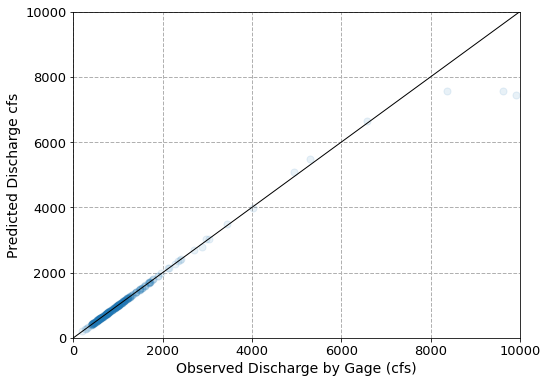

In [17]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

### SICK MAP

In [18]:
nisqually_loc = 46.75260766, -122.0837194
paradise_loc = 46.78, -121.75
Modis_loc = 46.783, -121.73
 

#### add in shapefile of the upstream basin and a centerline of our river...
[like this](https://waterdata.usgs.gov/monitoring-location/12082500/#parameterCode=00065&period=P7D)

In [19]:
fmap = folium.Map(location=[nisqually_loc[0],nisqually_loc[1]], zoom_start=9)
folium.Marker(nisqually_loc, popup='Nisqually Gage').add_to(fmap)
folium.Marker(paradise_loc, popup='Paradise Snotel').add_to(fmap)
folium.Marker(Modis_loc, popup='MODIS').add_to(fmap)
fmap

# PART 3 - MODIS thru GITHUB

In [20]:
#imports some repeated
import requests
import json
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'} # Use following for a csv response: header = {'Accept': 'text/csv'}

# Build time series from multiple requests


In [28]:
response = requests.get('https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/dates')
dates = json.loads(response.text)['dates']

modis_dates = [i['modis_date'] for i in dates]
calendar_dates = [i['calendar_date'] for i in dates]

In [29]:
response = requests.get('https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate=A2012001&endDate=A2013001', headers=header)

subset = json.loads(response.text)
subset

{'xllcorner': -1571750.0,
 'yllcorner': 654500.0,
 'cellsize': 1000.0,
 'nrows': 9,
 'ncols': 9,
 'band': 'prcp',
 'units': 'mm/day',
 'scale': '1',
 'latitude': 46.783333,
 'longitude': -121.733333,
 'header': 'https://modisrest.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate=A2012001&endDate=A2013001',
 'subset': [{'modis_date': 'A2012001',
   'calendar_date': '2012-01-01',
   'band': 'prcp',
   'tile': 'h09v04',
   'proc_date': '2020141080222',
   'data': [16.44,
    16.37,
    17.33,
    18.45,
    17.83,
    18.89,
    18.95,
    16.53,
    16.36,
    14.4,
    14.91,
    15.98,
    16.74,
    16.09,
    17.44,
    17.23,
    16.57,
    14.75,
    13.56,
    14.21,
    14.89,
    14.58,
    15.4,
    16.22,
    15.95,
    15.86,
    14.16,
    12.75,
    12.57,
    13.23,
    13.92,
    14.74,
    15.03,
    14.73,
    15.04,
    13.89,
    11.49,
    12.53,
    12.74,
    13.73,
    14.1,
    14.32,
    13.14,
    14.31,
  

In [30]:
siteid = 'us_washington_paradise_mount_rainier_national_park'
prod = 'Daymet' # MODIS product
data_band = 'prcp' # Daytime LST band name
qc_band = 'QC_Day' # Daytime QC band name
above_below = 15 # km above/below
left_right = 15 # km left/right

In [31]:
dates = modis_dates[modis_dates.index('A2012001'):modis_dates.index('A2013001')]

In [32]:
# Initialize lists to store the returned LST and QC data
lstdata = []
qcdata = []

# Iterate through the list of dates and submit subset requests for each date:
for dt in dates:
    
    # Join LST request parameters to URL string and submit request
    lstresponse = requests.get("".join([
        url, prod, '/' , siteid, "/subset?",
        "band=", data_band,
        "&startDate=", dt,
        "&endDate=", dt,
    ]), headers=header)

    # Append subset data to lstdata
    lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )
        
    # Join QC request parameters to URL string and submit request
    qcresponse = requests.get("".join([
        url, prod, '/',
        siteid, 
        "/subset?",
        "band=", data_band,
        "&startDate=", dt,
        "&endDate=", dt,
    ]), headers=header)

    
    # Append qc data to qcdata
    qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )


In [33]:
# Convert to real dates
dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

lstdata = pd.DataFrame(lstdata, index=dates)
qcdata = pd.DataFrame(qcdata, index=dates)

In [34]:
qcvals = pd.unique(qcdata.values.ravel())
qcvals

array([16.44, 16.37, 17.33, ...,  2.04,  1.96,  1.82])

In [35]:
# Create empty list to store QC bit information
QC_Data = []

# Iterate through the list of 8-bit integers and populate QC table with bit definitions 
for integer in range(0, 256, 1):
    bits = list(map(int, list("{0:b}".format(integer).zfill(8))))
    
    # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
    # Mandatory_QA bits description
    if (bits[6] == 0 and bits[7] == 0):
        Mandatory_QA = 'LST GOOD'
    if (bits[6] == 0 and bits[7] == 1):
        Mandatory_QA = 'LST Produced,Other Quality'
    if (bits[6] == 1 and bits[7] == 0):
        Mandatory_QA = 'No Pixel,clouds'
    if (bits[6] == 1 and bits[7] == 1):
        Mandatory_QA = 'No Pixel, Other QA'
        
    # Data_Quality bits description
    if (bits[4] == 0 and bits[5] == 0):
        Data_Quality = 'Good Data'
    if (bits[4] == 0 and bits[5] == 1):
        Data_Quality = 'Other Quality'
    if (bits[4] == 1 and bits[5] == 0):
        Data_Quality = 'TBD'
    if (bits[4] == 1 and bits[5] == 1):
        Data_Quality = 'TBD'
        
    # Emiss_Err bits description
    if (bits[2] == 0 and bits[3] == 0):
        Emiss_Err = 'Emiss Err <= .01'
    if (bits[2] == 0 and bits[3] == 1):
        Emiss_Err = 'Emiss Err <= .02'
    if (bits[2] == 1 and bits[3] == 0):
        Emiss_Err = 'Emiss Err <= .04'
    if (bits[2] == 1 and bits[3] == 1):
        Emiss_Err = 'Emiss Err > .04'
        
    # LST_Err bits description
    if (bits[0] == 0 and bits[1] == 0):
        LST_Err = 'LST Err <= 1K'
    if (bits[0] == 0 and bits[1] == 1):
        LST_Err = 'LST Err <= 3K'
    if (bits[0] == 1 and bits[1] == 0):
        LST_Err = 'LST Err <= 2K'
    if (bits[0] == 1 and bits[1] == 1):
        LST_Err = 'LST Err > 3K' 
    
    # Append this integers bit values and descriptions to list
    QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])
    

# Convert QC bits and descriptions to pandas data frame
QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Err <= .01,LST Err <= 1K
1,1,0,0,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <= .01,LST Err <= 1K
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K
4,4,0,0,0,0,0,1,0,0,LST GOOD,Other Quality,Emiss Err <= .01,LST Err <= 1K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,1,1,1,1,1,0,1,1,"No Pixel, Other QA",TBD,Emiss Err > .04,LST Err > 3K
252,252,1,1,1,1,1,1,0,0,LST GOOD,TBD,Emiss Err > .04,LST Err > 3K
253,253,1,1,1,1,1,1,0,1,"LST Produced,Other Quality",TBD,Emiss Err > .04,LST Err > 3K
254,254,1,1,1,1,1,1,1,0,"No Pixel,clouds",TBD,Emiss Err > .04,LST Err > 3K


In [36]:
QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Err <= .01,LST Err <= 1K
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K
4,4,0,0,0,0,0,1,0,0,LST GOOD,Other Quality,Emiss Err <= .01,LST Err <= 1K
5,5,0,0,0,0,0,1,0,1,"LST Produced,Other Quality",Other Quality,Emiss Err <= .01,LST Err <= 1K
6,6,0,0,0,0,0,1,1,0,"No Pixel,clouds",Other Quality,Emiss Err <= .01,LST Err <= 1K
7,7,0,0,0,0,0,1,1,1,"No Pixel, Other QA",Other Quality,Emiss Err <= .01,LST Err <= 1K
8,8,0,0,0,0,1,0,0,0,LST GOOD,TBD,Emiss Err <= .01,LST Err <= 1K
9,9,0,0,0,0,1,0,0,1,"LST Produced,Other Quality",TBD,Emiss Err <= .01,LST Err <= 1K
10,10,0,0,0,0,1,0,1,0,"No Pixel,clouds",TBD,Emiss Err <= .01,LST Err <= 1K


In [37]:
QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
QC_Data

,Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
2,2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <= .01,LST Err <= 1K
3,3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Err <= .01,LST Err <= 1K


In [38]:
filter = QC_Data['Integer_Value'].tolist()
lstdata_filt = lstdata.mask(qcdata.isin(filter))

In [39]:
scale = json.loads(response.text)['scale']
lstdata_filt_scale = lstdata_filt*float(scale)

ncol = int(json.loads(response.text)['ncols'])
nrow = int(json.loads(response.text)['nrows'])


lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
                                         lstdata_filt_scale.std(axis=1), 
                                         lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
                        columns=['mean', 'sd', 'quality'], index=dates)

# converting dataframe index to date time
lststats.index = pd.to_datetime(lststats.index)

lststats

,mean,sd,quality
2012-01-02,14.238395,1.862240,100.0
2012-01-03,6.640123,1.040426,100.0
2012-01-04,4.250247,0.688634,100.0
2012-01-05,12.239383,0.537374,100.0
2012-01-06,6.843951,0.161064,100.0
...,...,...,...
2012-12-27,19.138025,3.175053,100.0
2012-12-28,10.019753,2.005329,100.0
2012-12-29,0.000000,0.000000,100.0
2012-12-30,2.282099,0.263935,100.0


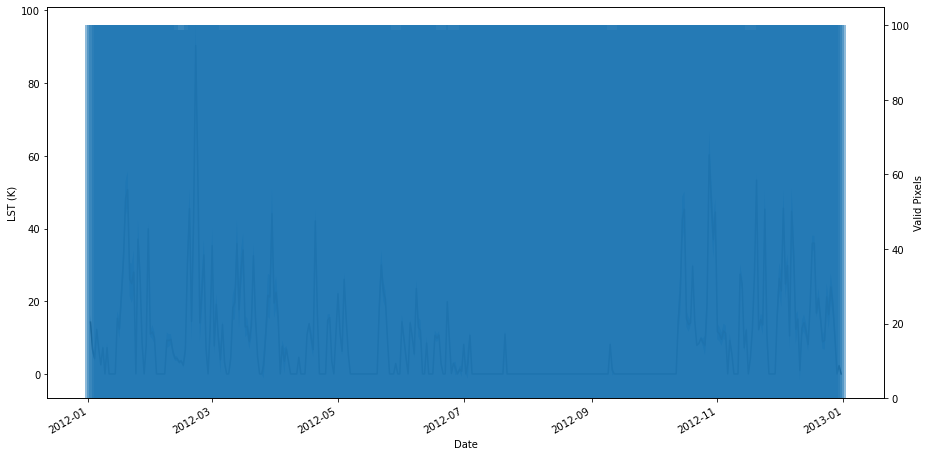

In [41]:
plt.rcParams['figure.figsize'] = (15,8)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('LST (K)')
ax1.plot(lststats.index, lststats['mean'], 'k-')
ax1.fill_between(lststats.index, lststats['mean']-lststats['sd'], lststats['mean']+lststats['sd'])
ax1.tick_params(axis='y')
fig.autofmt_xdate()

ax2 = ax1.twinx()
ax2.set_ylabel('Valid Pixels')
ax2.bar(lststats.index, lststats['quality'], 5, alpha = 0.5)
ax2.tick_params(axis='y')

plt.show()